In [1]:
import skimage.io as skio
import skimage
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
from filters import *
from tools import *
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random

import argparse
import logging
import os

import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

from UNet.utils.data_loading import BasicDataset
from UNet.unet import UNet
from UNet.utils.utils import plot_img_and_mask

from UNet.predict import predict_img

In [2]:
cd UNet

/home/jovyan/ml-project-2-cellseg_hyb/UNet


In [3]:
!python train.py -d 1

INFO: Using device cuda
INFO: Network:
	1 input channels
	1 output channels (classes)
	Transposed conv upscaling
INFO: Creating dataset with 184 examples
wandb: Currently logged in as: benjamin-bonnabaud. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.13.5
wandb: Run data is saved locally in /home/jovyan/ml-project-2-cellseg_hyb/UNet/wandb/run-20221205_162755-3lw2aa8g
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run copper-thunder-1
wandb: ⭐️ View project at https://wandb.ai/benjamin-bonnabaud/U-Net%20on%20PhC-C2DH-U373
wandb: 🚀 View run at https://wandb.ai/benjamin-bonnabaud/U-Net%20on%20PhC-C2DH-U373/runs/3lw2aa8g
INFO: Starting training:
        Dataset:         PhC-C2DH-U373
        Epochs:          5
        Batch size:      1
        Learning rate:   1e-05
        Training size:   166
        Validation size: 18
        Metric:          IoU
        Checkpoints:     True
        Device:          cuda
        Mixed Precision:

In [4]:
cd ..

/home/jovyan/ml-project-2-cellseg_hyb


In [5]:
DATASET = ['Fluo-N2DL-HeLa','PhC-C2DH-U373']
idx = 1

IM_TEST_PATH = sorted(glob.glob(f'data/{DATASET[idx]}/IMG_TEST/*.tif'))
TG_TEST_PATH = sorted(glob.glob(f'data/{DATASET[idx]}/TARGET_TEST/*.tif'))

X_test, y_test = load_img_tg(IM_TEST_PATH, TG_TEST_PATH)
print(len(X_test))

46


In [7]:
model = f'UNet/checkpoints/{DATASET[idx]}/checkpoint_epoch2.pth'

net = UNet(n_channels=1, n_classes=1, bilinear=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Loading model {model}')
print(f'Using device {device}')

net.to(device=device)
net.load_state_dict(torch.load(model, map_location=device))

print('Model loaded!')

Loading model UNet/checkpoints/PhC-C2DH-U373/checkpoint_epoch2.pth
Using device cuda
Model loaded!


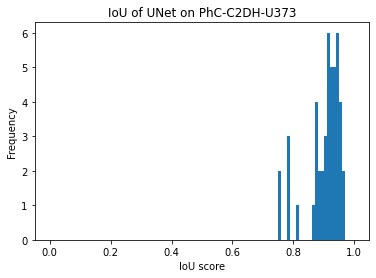

In [8]:
results = []
for i, (img,gt) in enumerate(zip(X_test, y_test)):
    #print(f'\nPredicting image {IM_TEST_PATH[i]} ...')

    pred = predict_img(net=net,
                       full_img=img,
                       device=device)

    results.append(jaccard_score(gt,pred,average='micro'))
plt.hist(results,bins=100,range=(0,1))
plt.title(f'IoU of UNet on {DATASET[idx]}')
plt.xlabel('IoU score')
plt.ylabel('Frequency')
plt.savefig(f'output/UNet_performance_dataset_{idx}.png')

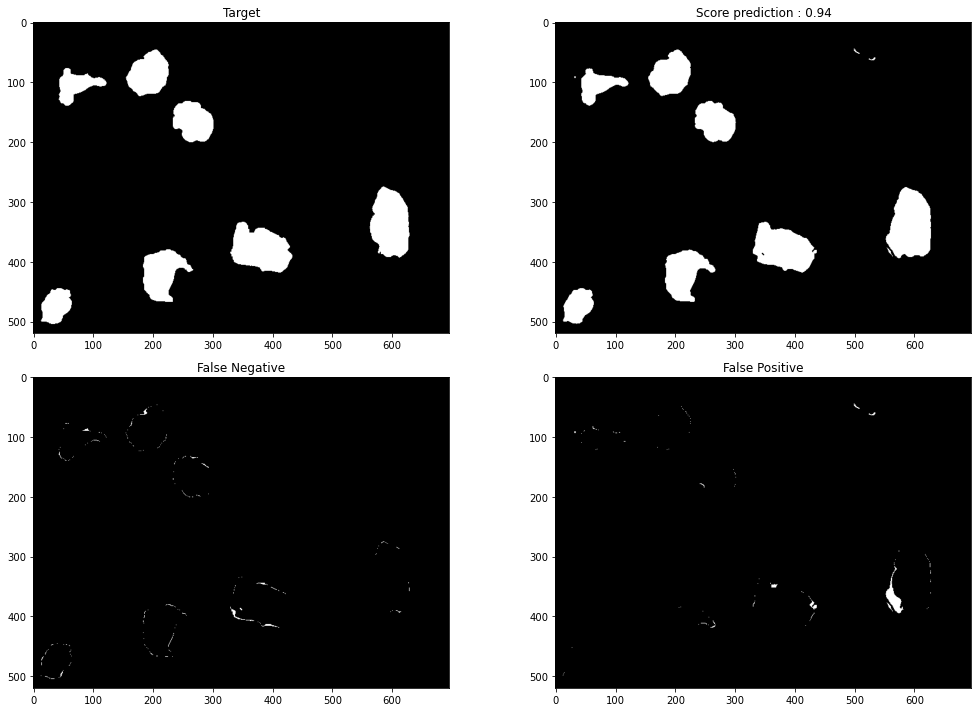

In [9]:
n_im = random.randrange(len(y_test))
target = y_test[n_im]
seg = predict_img(net=net,
                       full_img=X_test[n_im],
                       device=device)

score = jaccard_score(target,seg,average='micro')

fig = plot_pred_with_target(target,seg,score)
fig.savefig(f'output/inference_UNet_dataset_{idx}.png')